In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objs as go
from plotly import tools 
from plotly import offline
import plotly.plotly as py
import plotly.figure_factory as ff
from scipy import stats
import numpy as np
import warnings
warnings.filterwarnings('ignore')

The titanic data consists of 12 attributes.  Each attribute set is a 
description about a passenger that was on board the titanic.

Variables:
survival --> this is the class label that indicates if the passenger survived
or not.  
(0 = No and 1 = Yes)
pclass --> A proxy for socio-economic status (SES)
(1=upper, 2=Middle, 3=Lower)
sex --> the sex of the passenger
Age --> Age of passenger in years
(age: Age is fractional if less than 1. )
(If the age is estimated, is it in the form of xx.5)
sibsp --> # of siblings and spouses aboard the Titanic	
(Sibling = brother, sister, stepbrother, stepsister)
(Spouse = husband, wife (mistresses and fiancés were ignored))
parch --> # of parents and children aboard the Titanic	
(Parent = mother, father)
(Child = daughter, son, stepdaughter, stepson)
(Some children travelled only with a nanny, therefore parch=0 for them.)
ticket --> Ticket number	
fare --> ticket price 
cabin --> Cabin number	
embarked --> Port of Embarkation	
(C = Cherbourg, Q = Queenstown, S = Southampton)

Observations:
From the attribute description, I know that Pclass is ordinal
variable and can be converted to dummy variables for classification models or regression models.  Name is a nominal variable.  Sex is binary variable.  Embarked can be converted to dummy variable for models if needed.  SibSp and Parch can be used for feature engineering to create a family size.  It is possible to use name variable for feature engineering, but there can be a lot of typos and errors in this variable, which makes this variable not reliable.  Therefore, I stay away from it.  

In [2]:
train = pd.read_csv("C:/Users/Norman/Desktop/Code_Repo/Python_Projects/data/Titanic/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1. Detect Missing values
Getting a quick overview of each attribute.  

Obervations:
The training data has a total of 891 records.  Age, Cabin, Embarked have 
missing values. Age is a float data type.  The attribute description gives the reason as to why.  Besides this, the numeric attributes appear to be floats or ints, and not objects.  This indicates that there is no strings or weird symbols in those columns.  However, this does not mean that categorical attributes do not have weird symbols.  There is also the question "are there weird numbers in the numerical attributes?"  

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# 2.

Here I determine the percentage of missing values in each attribute.  

Observations:
I notice that Cabin has over 77% missing values.  Therefore, we don't consider
using that attribute.  Age has about 20% missing values.  However, age is an
important description about passengers.  Therefore, it would be unwise to drop
this attribute.  Still have to decide on what to do about the missing age 
values.  Noticed that Embarked attribute has 2 missing values.

In [4]:
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/
# pandas.isnull.html
# https://pandas.pydata.org/pandas-docs/stable/generated/
# pandas.DataFrame.sum.html
# https://pandas.pydata.org/pandas-docs/stable/generated/
# pandas.DataFrame.sort_values.html
missing = train.isnull().sum().sort_values(ascending=False)
# https://pandas.pydata.org/pandas-docs/stable/generated/
# pandas.DataFrame.count.html
# for w.e reason, if we use missing instead of train.isnull.sum(), the sorted
# values are not in the same place, which causes a problem with concat.  
percentage = (train.isnull().sum()/train.isnull().count()).sort_values(
        ascending=False)
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/
# pandas.concat.html
missing_info = pd.concat([missing,percentage], 
                         axis=1, keys=['Missing','Percentage'])
missing_info

,Missing,Percentage
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


# 3. Data Cleaning

PassengerId is equivalent to an index.  Ticket is also a random identifier. 
So I drop those column.  This was determined by reading the attribute 
descriptions.  
Cabin is dropped because it has a lot of missing values values and there is no way to imput it.

In [5]:
train.drop(["PassengerId", "Ticket", "Cabin"], axis=1, inplace=True)

# 4. 

Exploring the min and max of each attribute in order to determine if the
attributes contains records that are within the expected range.  

Observations:
Survived has a max value of 1 and a min value of 0. 
P class has a min value of 1 and a max value of 3.
Age has a min value of .42 and a max value of 80. 
(The reason for the observed min value is explained in data description)
SibSp has a min value of 0 and max value of 8
Parch has a max value of 6 and a min value of 0
Fare has a min value of 0 and a max value of 512. 
(How can someone have a ticket price of 0 or 512?)

In [6]:
sum_stats = train.describe()
for i in sum_stats.columns:
    print(sum_stats[i], '\n')

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64 

count    891.000000
mean       2.308642
std        0.836071
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64 

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64 

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64 

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64 

count    891.000000
mean      32.204208
std     

# 5. 

I fixed the missing values in the Embarked variable.  The values 
could be inputed with the most frequent category.The reason is that there are
so few missing values, the mode is definately not wrong.  
If there was a lot of missing values
for a categorical attribute, you cannot be sure if the mode is wrong or not.  
Lets say there is 300 values for category A, 200 values for category B, and 
200 missing values.  If it turns out that the missing values belong to category
B and we imputed the 200 missing values with the mode, which is category A, 
then we would have made a mistake and erroneously affected the distribution
of the variable. 

I fix the Age variable by imputing with the median.  Although not shown here,
I know that the Age variable is has a slight positive skew.  Therefore, 
the median is a better representation of the expected value of the variable.  

In [7]:
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
train['Age'].fillna(train['Age'].median(), inplace=True)
train.head()    

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


# 6. Feature Creation

I decided to create a feature for family size.  This attribute is the sum of 
Sibsp, Parch attributes and 1.  It might be reasonable to believe that the 
family size might affect a person's chances of survival.  Maybe a big family 
would be more likely to be let on a boat.  Maybe if you have a large family, 
there are more people looking after you, so it might make sense that you are 
more likely to survive.  The value 1 is added to include the person in the 
family.  

It might also be reasonable to believe that being alone on the boat would 
have an impact on your chances of survival.  Therefore, I create a binary 
feature called alone.  The value is 1 if you are alone and 0 if you are with
your family.  

In [8]:
train['Family_Size'] = train['SibSp'] + train['Parch'] + 1
train['Alone'] = train['Family_Size'] <= 1
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Family_Size,Alone
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,False
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,False
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,True
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,False
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,True


# 7.  Exploratory Data Analysis (EDA)
Exploring the distribution of the quantitative attributes: Age, Fare, SibSp, 
Parch using histograms.

Age has missing values, so the distribution might be affected by 
the missing values.  ipy.stat.probplot handles missing values in a weird fashion. I think it is best to remove the Na's before plotting the qqplot.  That way the qqplot is representative of the corresponding histogram.  

In [9]:
fig = tools.make_subplots(rows=4, cols=2, subplot_titles=('Age', 'qqnorm Age',
                                                        'Fare', 'qqnorm Fare',
                                                      'SibSp', 'qqnorm SibSp',
                                                     'Parch', 'qqnorm Parch'))
dist_0 = []
dist_1 = []
qq = []
names = ['Age', 'Fare', 'SibSp', 'Parch']
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html
# https://plot.ly/python/reference/#histogram
for i in names:
    temp = train[i].dropna()
    dist_0.append(go.Histogram(x=temp.loc[train['Survived']==0,],
                               opacity=.8, name='Dead'))
    dist_1.append(go.Histogram(x=temp.loc[train['Survived']==1,],
                               opacity=.8, name='Survived'))
    qq.append(stats.probplot(temp, dist='norm'))
for i in range(0,4):
    fig.append_trace(dist_0[i], i+1, 1)
    fig.append_trace(dist_1[i], i+1, 1)
    x = np.array([qq[i][0][0][0], qq[i][0][0][-1]])
    pts = go.Scatter(x=qq[i][0][0],
                 y=qq[i][0][1], 
                 mode = 'markers',
                 showlegend=False
                )
    line = go.Scatter(x=x,
                  y=(qq[i][1][1] + qq[i][1][0]*x),
                  showlegend=False,
                  mode='lines'
                 )
    fig.append_trace(pts, (i+1), 2)
    fig.append_trace(line, (i+1), 2)
fig['layout'].update(title='Multiple Subplots', barmode='overlay')
py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]
[ (4,1) x7,y7 ]  [ (4,2) x8,y8 ]



# 8.
Creating a 2d Histogram Contour plot to visualize the relationship between
two continuous variables, Age and Fare.  

In [10]:
# Have to include a layout to label the axis and title and color scheme.  
fig = ff.create_2d_density(train['Age'], train['Fare'], point_size=5)
py.iplot(fig)

# 9. 
Creating a scatterplot matrix to visualize pair-wise correlations between
every variable.  This is to identify possible non-linear pair-wise 
correlations.  This is a way to tackle multicollinearity, but is not perfect
method.  The reason being is just because 2 variables are not pair-wise 
corrleated does not mean that a variable x1 is not correlated to another 
variable x2 when controlling for variables x3, x4, ...
The main reason to do this is to eliminate redundant attributes.  

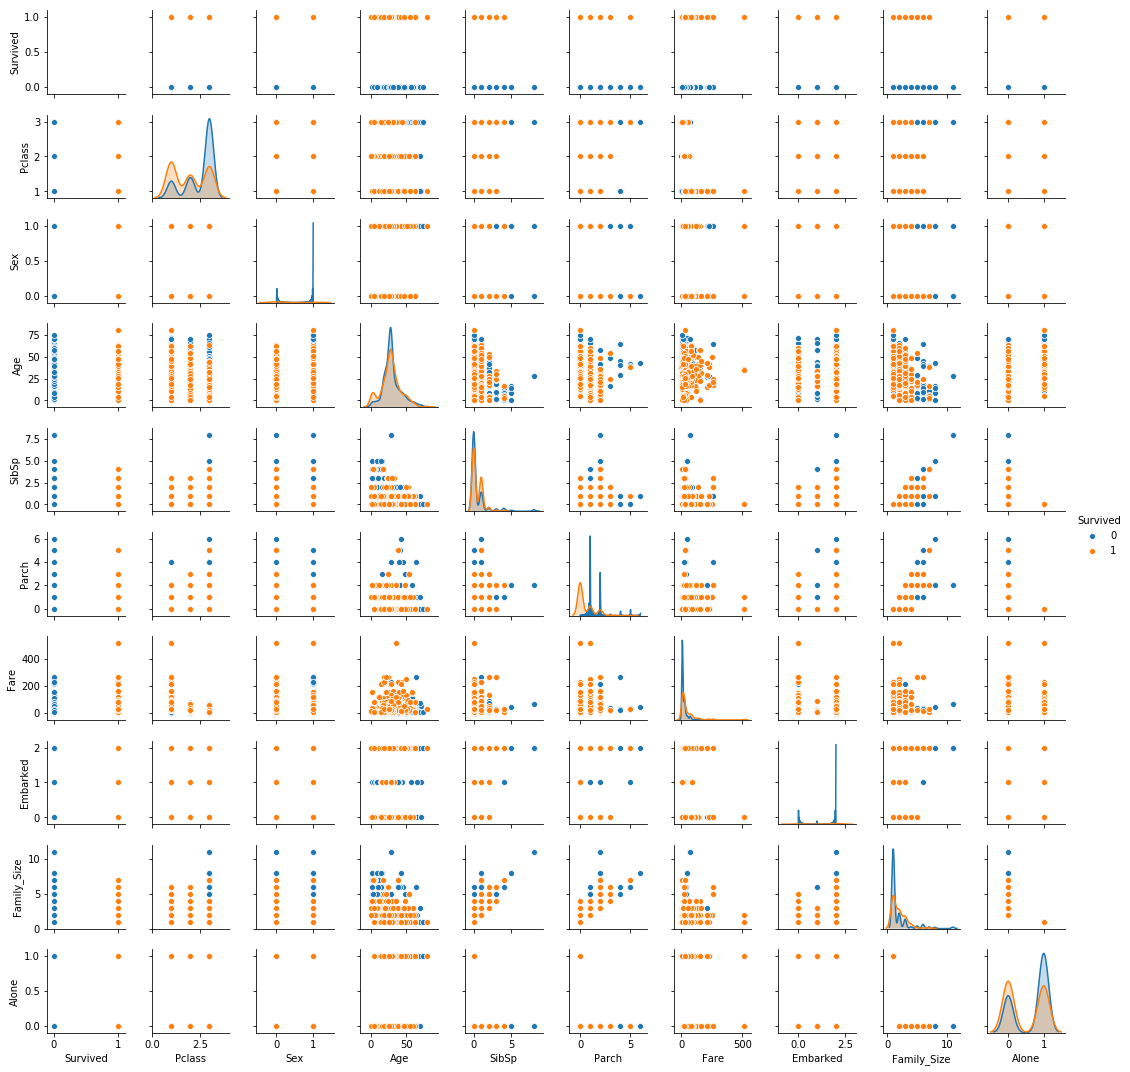

In [11]:
# https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.unique.html
# https://docs.scipy.org/doc/numpy/reference/generated/
# numpy.ndarray.tolist.html
trainCopy = train.copy()
sex = np.unique(train['Sex'].values).tolist()
sex_code = {sex[i]:i for i in range(2)} # female=0, male=1
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html
# have to map strings to numbers or else the pairplot method will not plot the
# variable.  
# Encoded Embarked into numerical values so it will show up in the scatterplot
# matrix.
trainCopy['Sex'] = train['Sex'].map(sex_code)
em = np.unique(train['Embarked'].values).tolist()
em_code = {em[i]:i for i in range(3)}
trainCopy['Embarked'] = train['Embarked'].map(em_code)
alone_code = {True:1, False:0}
trainCopy['Alone'] = train['Alone'].map(alone_code)
sns.pairplot(trainCopy, hue='Survived', size=1.5)
plt.show()

# 10. 

Looking at the frequency of survival for different subpopulations.  
(Looking at distribution of different categorical variables)


Text(0.5, 1.0, 'Number of Survivals by number of parents and children')

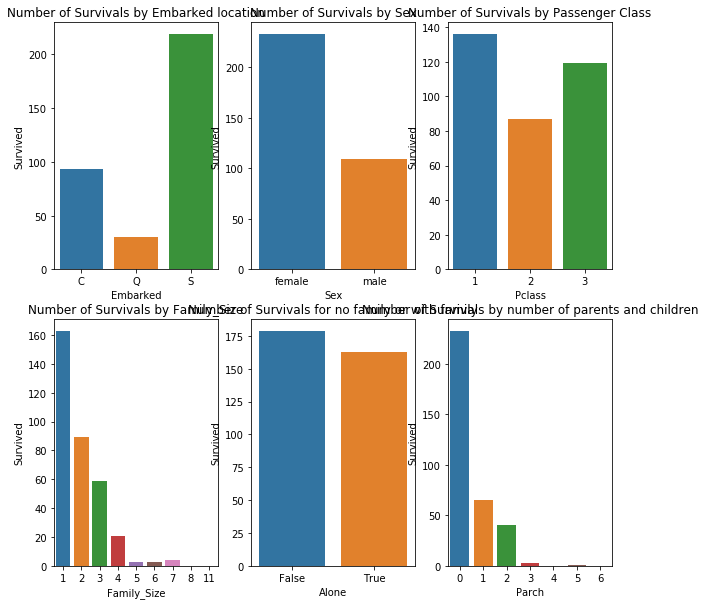

In [12]:
# https://pandas.pydata.org/pandas-docs/stable/generated/
# pandas.DataFrame.groupby.html
f, axes = plt.subplots(2, 3, figsize=(10,10))
temp = train[['Survived', 'Embarked']].groupby(by='Embarked').sum()
# https://pandas.pydata.org/pandas-docs/stable/generated/
# pandas.DataFrame.reset_index.html
temp.reset_index(inplace=True) # This is used to create sex attribute
# https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='Embarked', y='Survived', data=temp, ax=axes[0,0])
axes[0,0].set_title("Number of Survivals by Embarked location")

temp = train[['Survived', 'Sex']].groupby(by='Sex').sum()
temp.reset_index(inplace=True) # This is used to create sex attribute
sns.barplot(x='Sex', y='Survived', data=temp, ax=axes[0,1])
axes[0,1].set_title("Number of Survivals by Sex")

temp = train[['Survived', 'Pclass']].groupby(by='Pclass').sum()
temp.reset_index(inplace=True) # This is used to create sex attribute
sns.barplot(x='Pclass', y='Survived', data=temp, ax=axes[0,2])
axes[0,2].set_title("Number of Survivals by Passenger Class")

temp = train[['Survived', 'Family_Size']].groupby(by='Family_Size').sum()
temp.reset_index(inplace=True) # This is used to create sex attribute
sns.barplot(x='Family_Size', y='Survived', data=temp, ax=axes[1,0])
axes[1,0].set_title("Number of Survivals by Family_Size")

temp = train[['Survived', 'Alone']].groupby(by='Alone').sum()
temp.reset_index(inplace=True) # This is used to create sex attribute
sns.barplot(x='Alone', y='Survived', data=temp, ax=axes[1,1])
axes[1,1].set_title("Number of Survivals for no family or with family")

temp = train[['Survived', 'Parch']].groupby(by='Parch').sum()
temp.reset_index(inplace=True) # This is used to create sex attribute
sns.barplot(x='Parch', y='Survived', data=temp, ax=axes[1,2])
axes[1,2].set_title("Number of Survivals by number of parents and children")


# 11.

Looking at boxplots of Age, Fare, Family size.  (continuous variables)

Text(0.5, 1.0, 'Family size boxplot by survival')

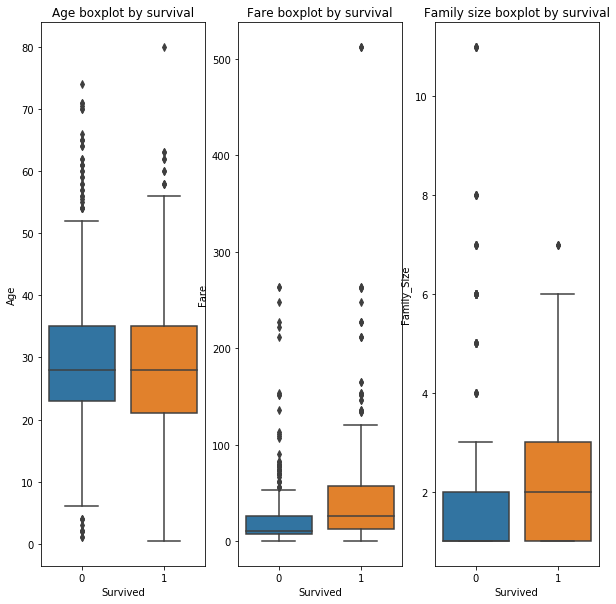

In [13]:
f, axes = plt.subplots(1, 3, figsize=(10,10))
sns.boxplot(x='Survived', y= 'Age', data=train, ax=axes[0])
axes[0].set_title('Age boxplot by survival')

sns.boxplot(x='Survived', y= 'Fare', data=train, ax=axes[1])
axes[1].set_title('Fare boxplot by survival')

sns.boxplot(x='Survived', y= 'Family_Size', data=train, ax=axes[2])
axes[2].set_title('Family size boxplot by survival')


# 12.

Creating plots that compares 2 variables and split the population
by 1 categorical variable.  

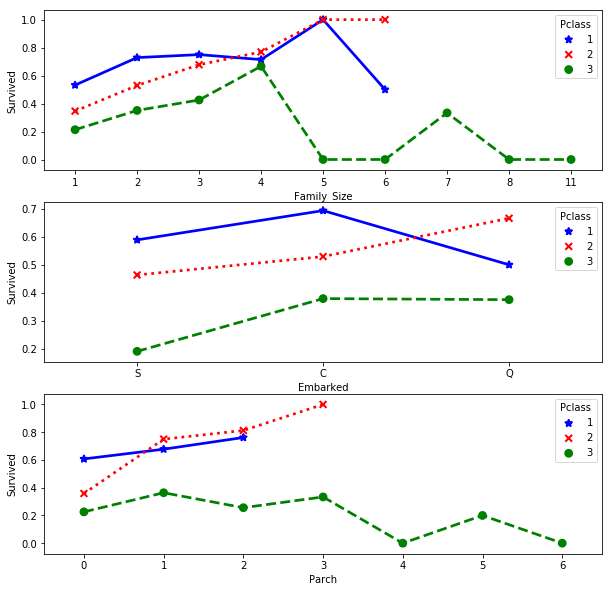

In [14]:
f, axes = plt.subplots(3, 1, figsize=(10,10))
sns.pointplot(x="Family_Size", y="Survived", hue="Pclass", data=train,
              palette={1:"blue", 2:"red",3:"green"},
              markers=["*", "x", "o"], linestyles=["-",":", "--"], ci=None,
              ax=axes[0])
sns.pointplot(x="Embarked", y="Survived", hue="Pclass", data=train,
              palette={1:"blue", 2:"red",3:"green"},
              markers=["*", "x", "o"], linestyles=["-",":", "--"], ci=None,
              ax=axes[1])
sns.pointplot(x="Parch", y="Survived", hue="Pclass", data=train,
              palette={1:"blue", 2:"red",3:"green"},
              markers=["*", "x", "o"], linestyles=["-",":", "--"], ci=None,
              ax=axes[2])

# 13. 

Creating plots that compares 2 variables and split the population
by 1 categorical variable.  

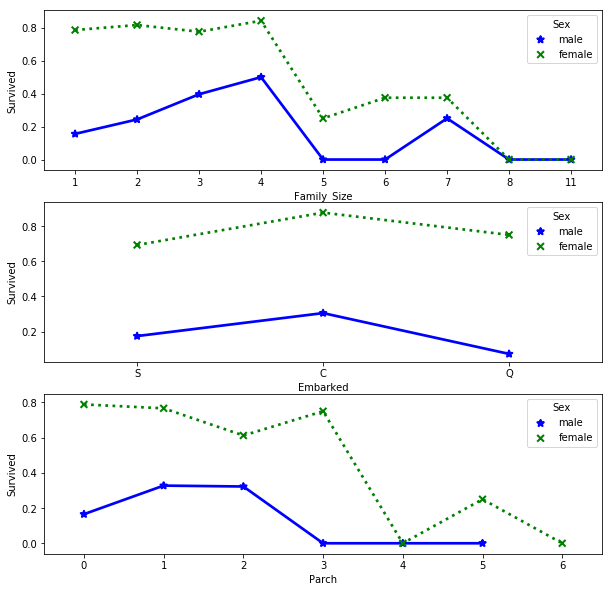

In [15]:
f, axes = plt.subplots(3, 1, figsize=(10,10))
sns.pointplot(x="Family_Size", y="Survived", hue="Sex", data=train,
              palette={'male':"blue", 'female':"green"},
              markers=["*", "x"], linestyles=["-",":"], ci=None,
              ax=axes[0])
sns.pointplot(x="Embarked", y="Survived", hue="Sex", data=train,
              palette={'male':"blue",'female':"green"},
              markers=["*", "x"], linestyles=["-",":"], ci=None,
              ax=axes[1])
sns.pointplot(x="Parch", y="Survived", hue="Sex", data=train,
              palette={'male':"blue", 'female':"green"},
              markers=["*", "x"], linestyles=["-",":"], ci=None,
              ax=axes[2])

# 14.
Creating a correlation heatmap between relevant input attributes and the 
class label.   

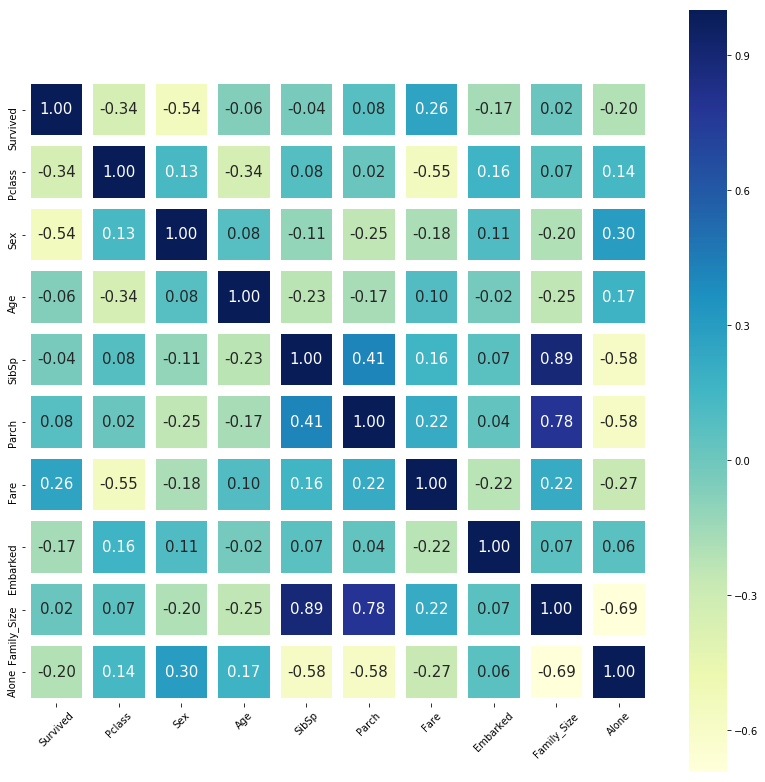

In [16]:
corr_10 = trainCopy.corr()
plt.figure(figsize=(14,14))
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(corr_10, cbar=True, square=True, annot=True, fmt='.2f', annot_kws={
        'size':15}, cmap='YlGnBu', linewidths=10)
# https://stackoverflow.com/questions/26540035/
# rotate-label-text-in-seaborn-factorplot
# plt.xticks is used to turn the horizontal labels into diagonal labels
plt.xticks(rotation=45)
plt.show()